## Semantic and Mention Network Analysis on Twitter Data
*Kenneth Miller*
Using Twitter data and network analysis techniques I will create two networks of tweets about three car brands over the course of this notebook: Toyota, Honda, and Jeep. Each network will allow us to see different interactions between these car companies and those that mention them; the semantic network will allow us to see what words are used in conjunction with which brands and the mention network will allow us to see the social connections between groups that mention each brand.


### Pulling data from Twitter

In [102]:
import json
import os 
import sys
import time
from zipfile import ZipFile
from birdy.twitter import AppClient, UserClient, TwitterRateLimitError
from ratelimiter import RateLimiter
from IPython.display import Image

In [2]:
CONSUMER_KEY = 'KEY'
CONSUMER_SECRET = 'SECRET'


OUTPUT_DIR = 'tweets'
MAX_TWEETS = 10000 # max results for a search
max_id = None
_client = None

In [103]:
def client(consumer_key=None, consumer_secret=None):
    global _client
    if consumer_key is None:
        consumer_key = CONSUMER_KEY
    if consumer_secret is None:
        consumer_secret = CONSUMER_SECRET
    if _client is None:
        _client = AppClient(consumer_key, consumer_secret)
        access_token = _client.get_access_token()
        _client = AppClient(consumer_key, consumer_secret, access_token)
    return _client


def limited(until):
    duration = int(round(until - time.time()))
    print('Rate limited, sleeping for {:d} seconds'.format(duration))


@RateLimiter(max_calls=440, period=60*15, callback=limited)
def fetch_tweets(query, consumer_key=None, consumer_secret=None):
    global max_id
    print(f'Fetching: "{query}" TO MAX ID: {max_id}')
    try:
        tweets = client(consumer_key, consumer_secret).api.search.tweets.get(
            q=query,
            count=100,
            max_id=max_id).data['statuses']
    except TwitterRateLimitError:
        sys.exit("You've reached your Twitter API rate limit. "\
            "Wait 15 minutes before trying again")
    try:
        id_ = min([tweet['id'] for tweet in tweets])
    except ValueError:
        return None
    if max_id is None or id_ <= max_id:
        max_id = id_ - 1
    return tweets


def initialize_max_id(file_list):
    global max_id
    for fn in file_list:
        n = int(fn.split('.')[0])
        if max_id is None or n < max_id:
            max_id = n - 1
    if max_id is not None:
        print('Found previously fetched tweets. Setting max_id to %d' % max_id)


def halt(_id):
    print('Reached historically fetched ID: %d' % _id)
    print('In order to re-fetch older tweets, ' \
        'remove tweets from the output directory or output zip file.')
    sys.exit('\n!!IMPORTANT: Tweets older than 7 days will not be re-fetched')


def search_twitter(query, consumer_key=None, consumer_secret=None,
            newtweets=False, dozip=True, verbose=False):
    output_dir = os.path.join(OUTPUT_DIR, '_'.join(query.split()))
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    if dozip:
        fn = os.path.join(output_dir, '%s.zip' % '_'.join(query.split()))
        outzip = ZipFile(fn, 'a')
    if not newtweets:
        if dozip:
            file_list = [f for f in outzip.namelist() if f.endswith('.json')]
        else:
            file_list = [f for f in os.listdir(output_dir) if f.endswith('.json')]
        initialize_max_id(file_list)
    while True:
        try:
            tweets = fetch_tweets(
                query,
                consumer_key=consumer_key,
                consumer_secret=consumer_secret)
            if tweets is None:
                print('Search Completed')
                if dozip:
                    outzip.close()
                break
            for tweet in tweets:
                if verbose:
                    print(tweet['id'])
                fn = '%d.json' % tweet['id']
                if dozip:
                    if fn in (file_list):
                        outzip.close()
                        halt(tweet['id'])
                    else:
                        outzip.writestr(fn, json.dumps(tweet, indent=4))
                        file_list.append(fn)
                else:
                    path = os.path.join(output_dir, fn)
                    if fn in (file_list):
                        halt(tweet['id'])
                    else:
                        with open(path, 'w') as outfile:
                            json.dump(tweet, outfile, indent=4)
                        file_list.append(fn)
                if len(file_list) >= MAX_TWEETS:
                    if fn in (file_list):
                        outzip.close()
                    sys.exit('Reached maximum tweet limit of: %d' % MAX_TWEETS)
        except:
            if dozip:
                outzip.close()
            raise

In [6]:
search_twitter("honda")
search_twitter("toyota usa OR toyota")
search_twitter("jeep")
# Add :) for positive tweets, :( for negative tweets

### Building a Mention Network

#### Importing necessary packages and creating a temporary directory to store unzipped tweets in.

In [104]:
import glob
import os
import shutil
import zipfile
import json
import csv
import pandas as pd

In [105]:
tempdir = 'temp'
if not os.path.exists(tempdir):
    os.makedirs(tempdir)
    print('Created temp directory.')
else:
    print('Directory already exists.')

Created temp directory.


Here, I'll unzip each zip file full of tweets and add the unzipped files to the temporary directory. 

In [106]:
tweetzipfiles = glob.glob('*.zip')
tweetzipfiles

['toyota_usa_OR_toyota.zip', 'jeep.zip', 'honda.zip']

In [107]:
for tweetfile in tweetzipfiles:
    with zipfile.ZipFile(tweetfile, 'r') as f:
        print('Unzipping %s to %s directory' % (tweetfile, tempdir))
        f.extractall(tempdir)

Unzipping toyota_usa_OR_toyota.zip to temp directory
Unzipping jeep.zip to temp directory
Unzipping honda.zip to temp directory


#### Creating dictionary of tweet counts.
With the files in the temporary directory, we will be able to create a dictionary of unique users, as well as the number of tweets they have in our dataset. For our purposes, we'll only keep users with more than two tweets. This gives us a set of 894 unique users - plenty for a mention network.

In [108]:
uniqueusers = {}
ct = 0

for file in os.listdir(tempdir):
    file = os.path.join(tempdir, file)
    #print(fn)
    with open(file) as f:
        ct += 1
        #if ct % 1000 == 0:
        #    print(ct, ' Tweets Unpacked')
        tweetjson = json.load(f)
        tweeter = tweetjson['user']['screen_name']
        
        if tweeter in uniqueusers:
            uniqueusers[tweeter] += 1
        if tweeter not in uniqueusers:
            uniqueusers[tweeter] = 1
print(ct, ' Tweets Unpacked')

29595  Tweets Unpacked


In [109]:
users_include = set()
usercount = 0
for user in uniqueusers:
    if uniqueusers[user] > 2:
        users_include.add(user)
print('Users with more than two tweets: %s' % len(users_include))

Users with more than two tweets: 894


#### Creating an edgelist for Gephi visualization
With our set of unique users with more than two tweets, I will now create an edgelist in the form of a csv that gives us a column of tweeter *Source* and a column of the user being mentioned *Target*. With this information, we will be able to construct a visualized mention network.

In [110]:
edgelist = open('car.edgelist.mention.gephi.csv', 'w')
csvwriter = csv.writer(edgelist)
header= ['Source', 'Target']
csvwriter.writerow(header)

print('Writing edge list')
ct = 0

for file in os.listdir(tempdir):
    file = os.path.join(tempdir, file)
    with open(file) as f:
        tweetjson = json.load(f)
        tweeter = tweetjson['user']['screen_name']
        if tweeter in users_include:
            ct += 1
            if ct % 1000 == 0:
                print(ct, ' Tweets written to edgelist')
            
            mentioned = tweetjson['entities']['user_mentions']
            if len(mentioned) > 0:
                for user in mentioned:
                    ment_screename = user['screen_name']
                    row = [tweeter, ment_screename]
                    csvwriter.writerow(row)
edgelist.close()
print('Done %s tweets written to edgelist.' % ct)

Writing edge list
1000  Tweets written to edgelist
2000  Tweets written to edgelist
3000  Tweets written to edgelist
4000  Tweets written to edgelist
5000  Tweets written to edgelist
Done 5952 tweets written to edgelist.


#### Removing the temporary directory.

In [111]:
shutil.rmtree(tempdir)

#### Full Mention Network
As we can see below, the mention network is clustered into three distinct areas, one surrounding Jeep (orange) and two surrounding Honda (blue) and Toyota (green). Surprisingly, Honda has almost no mentions at all. As expected, Jeep is fairly distinct from Honda and Toyota. Toyota absolutely has the most mentions and the biggest network.

                                                        Full Mention Network
![Full Mention Network](mentionimg/FullMention.png)
The Toyota Network is separated into two distinct clusters: one with mentions surrounding our search handle "Toyota" and one that came up naturally - "Toyota Hybrid". This is an interesting, but misleading insight - Twitter users are talking about "Toyota_Hybrid" quite often, however this is the handle of Toyota's Gazoo Racing Team, their official racing team. This makes much more sense when regarding Twitter users and culture; Twitter users are talking about more about motorsport, and not as much about Toyota's hybrid technologies. "Toyota_GR" and "Toyota_PR" are also two handles that are mentioned frequently and are found at the center of Toyota clusters. The first handle is another racing handle for Toyota Gazoo Racing and the second is the Japanese handle for Toyota as a whole. It is surprising to me personally that so much Twitter chatter about Toyota revolves around racing.

As one can see, Honda has a single mention edge with a Twitter user that also mentions Toyota quite frequently. This seems to show that Honda is not as "cool" as Toyota and Jeep or perhaps Toyota steals the spotlight from Honda. I am surprised that Honda's racing teams are not present in this mention network.

                                                        Toyota Network
![Toyota Network](mentionimg/ToyotaMention.png)

Below, we can see that the Jeep network is extremely distinct from Honda and Toyota, which suggests something that we already know about Jeep: it is different from Honda and Toyota because it is an American car company specializing in "outdoorsy" or "rugged" SUVs whereas the other two are Japanese car companies with a full car lineup, often known for reliability and economy. I would expect Jeep's mention network to be completely distinct as we see here. This is in contrast to Toyota where it would appear their second node is mostly about racing pedigree and maybe their technology, particularly hybrids. 

Jeep's network is centered around two major nodes: "Jeep" (our search term) and "THEJeepMafia", a Jeep Wrangler off-roading enthusiast group. This says a lot about Jeep and what the brand is known for: off-roading and particularly the Jeep Wrangler. Other common nodes for Jeep are "JeepsGreen", "topJeepers" and "Jeep Federation". All three of these handles are dedicated to Jeep Wrangler enthusiast and Jeep Federation is particularly interested in modifcations for off-road. This is a very common thread in the Jeep cluster and it makes sense too; the Jeep Wrangler is Jeep's "hero" car and it makes sense that it is the model that everyone is talking about.
                                                        
                                                        Jeep Network
![Jeep Network](mentionimg/JeepMention.png)

### Creating a Semantic Network

#### Importing packages and creating functions to deal with text analysis.
With these important text-analysis steps locked into functions, we will be able to repeat steps without taking up a lot of lines of code.

In [112]:
import nltk
wn = nltk.WordNetLemmatizer()
ps = nltk.PorterStemmer()

import glob
import os
import re
import shutil
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
#nltk.download('stopwords')
#nltk.download('punkt')
#nltk.download('wordnet')

import csv
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()
import string
import itertools
import zipfile
import json
punctuation = string.punctuation
stopwordsset = set(stopwords.words("english"))
stopwordsset.add("'s")

#Removing urls
def removeURL(text):
    result = re.sub(r"http\S+", "", text)
    return result

#Extracting contextual words from a sentence
def tokenize(text):
    #lower case
    text = text.lower()
    #split into individual words
    words = word_tokenize(text)
    return words

def stem(tokenizedtext):
    rootwords = []
    for aword in tokenizedtext:
        aword = ps.stem(aword)
        rootwords.append(aword)
    return rootwords

def stopWords(tokenizedtext):
    goodwords = []
    for aword in tokenizedtext:
        if aword not in stopwordsset:
            goodwords.append(aword)
    return goodwords

def lemmatizer(tokenizedtext):
    lemmawords = []
    for aword in tokenizedtext:
        aword = wn.lemmatize(aword)
        lemmawords.append(aword)
    return lemmawords

def removePunctuation(tokenizedtext):
    nopunctwords = []
    for aword in tokenizedtext:
        if aword not in punctuation:
            nopunctwords.append(aword)
    cleanedwords = []
    for aword in nopunctwords:
        aword = aword.translate(str.maketrans('', '', string.punctuation))
        cleanedwords.append(aword)
    return cleanedwords

#### Creating temporary directory.
Once again, I created a temporary directory to hold the unzipped tweets while I work on them to create an edgelist. In this case, I extracted the unique words from each tweet rather than the unique users, so that we can see the topics of each tweet to better understand our brands and what people think of them. To do this, the URLs have been removed from the tweets as well as the punctuation, and the stop words. From there the text was separated into separate words rather than long strings.

In [113]:
tempdir = 'tmp'
if not os.path.exists(tempdir):
    os.makedirs(tempdir)
    
tweetzipfiles = glob.glob('*zip')

for file in tweetzipfiles:
    with zipfile.ZipFile(file, 'r') as f:
        print('Unzipping to tmp directory: %s' % file)
        f.extractall(tempdir)

Unzipping to tmp directory: toyota_usa_OR_toyota.zip
Unzipping to tmp directory: jeep.zip
Unzipping to tmp directory: honda.zip


In [114]:
uniquewords = {}
ct = 0
for fn in os.listdir(tempdir):
    name = os.path.join(tempdir, fn)
    with open(name) as f:
        tweetjson = json.load(f)
        
        if tweetjson['lang'] == 'en':
            ct += 1
            text = tweetjson['text']
            nourlstext = removeURL(text)
            tokenizedtext = tokenize(nourlstext)
            nostopwords = stopWords(tokenizedtext)
            lemmatized = lemmatizer(nostopwords)
            nopunct = removePunctuation(lemmatized)
            
            for word in nopunct:
                if word in uniquewords:
                    uniquewords[word] += 1
                elif word not in uniquewords:
                    uniquewords[word] = 1
print('Tweets loaded: %s' % ct)

Tweets loaded: 13339


#### Creating a set of unique words
Here I created a set of unique words mentioned in the tweets that were mentioned more than 100 times. We want to capture the most common sentiments to gain more insight and to cut down on the amount of guff when it comes to visualizing the network. In this case there are 220 unique words that were mentioned more than 100 times. This large cut-off is necessary due to the huge amount of Tweets that we have in the data. If we were to allow any tweet into the data, the semantic network visualization would be unreadable due to the complexity and frequency of edges.

In [115]:
wordstoinclude = set()
wordcount = 0
for word in uniquewords:
    if uniquewords[word] > 100:
        wordcount += 1
        wordstoinclude.add(word)
print(wordcount)

220


#### Creating an edgelist for the semantic network visualization in Gephi.
From here, like before we are able to take our set of unique words and compare it to our tweet information. If the words are present in the set, we will then write a row to each possible combination of those words that appear in the tweet. 

For example if the tweet is `I love Jeeps`, three rows in the edglist will be written:
* I Jeeps
* love Jeeps
* I love

This is similar to the mention network in that it is two connections, however it is with semantic infromation. The third column in the edglist will simply read `Undirected` to tell Gephi that this is not a directed network; one word is not speaking *to* the other word, they're just found in conjunction.

In [116]:
edgelist = open('car_semantic_edglist_gephi2.csv', 'w')
csvwriter = csv.writer(edgelist)

header = ['Source', 'Target', 'Type']
csvwriter.writerow(header)
print('Writing Edgelist')


uniquewords = {}
ct = 0
for fn in os.listdir(tempdir):
    name = os.path.join(tempdir, fn)
    with open(name) as f:
        tweetjson = json.load(f)
        
        # Making sure the tweets are in English (important for semantics in English)
        if tweetjson['lang'] == 'en':
            ct += 1
            text = tweetjson['text']
            nourlstext = removeURL(text)
            tokenizedtext = tokenize(nourlstext)
            nostopwords = stopWords(tokenizedtext)
            lemmatized = lemmatizer(nostopwords)
            nopunct = removePunctuation(lemmatized)
            
            # Creating a list of goodwords using the previous set
            goodwords = []
            for word in nopunct:
                if word in wordstoinclude:
                    goodwords.append(word.replace(',', ''))
            
            # Creating a list of combination of words that could have gone together
            # Writing the csv rows one at a time
            combos = itertools.combinations(goodwords, 2) # list of words and the number of connections we want
            for combo in combos:
                row = []
                for node in combo:
                    row.append(node)
                row.append('Undirected')
                csvwriter.writerow(row)
print('Done. %s Tweets written to edglist.' % ct)
edgelist.close()

Writing Edgelist
Done. 13339 Tweets written to edglist.


#### Semantic Network
Below, one can see the full semantic network. Interestingly, this network was focused around model names and most of the major clusters from the mention network were not present, with the exception of "Toyota_Hybrid" - the Toyota Racing team. I have colored the models to their respective brand colors: Jeep (orange), Toyota (green), and Honda (blue). Interestingly, there are many more brands present in this semantic network than our original three including: Rolls Royce, Mercedes, Volkswagen, Nissan, Ford, Range Rover, BMW, etc. It would appear that this semantic network is dominated by car talk overall, and not necessarily specific to our three brands. However there are some interesting branches as outlined below.

Overall, this network did not provide much insight into Twitter user's views of our three brands and most of the models were very close together. It would appear that "Uber" is situated near Rav4 and Camry, indicating that perhaps these cars are popular choices for Uber drivers, perhaps highlighting their efficiency. Additionally, near the Wrangler and Accord nodes, it would appear that people are talking about buying these cars used as opposed to new. This might be an indication that these cars are too expensive new and perhaps could benefit from a price cut.

With this in mind, I have indicated a couple of network arms that I found intriguing or informative below.

                                                     Full Semantic Network
![Full Semantic](semanticimg/FullSemantic.png)

Below is an arm of the full semantic network that shows the "Toyota Hybrid" handle and various racing semantics such as "lap" and "TS050" which is a hybrid Le Mans race car. This semantic network arm confirms that Twitter users are indeed talking about the racing team and not talking about general Toyota hybrid technology. Additionally, there is a positive node in there: "Astonish.." which I assume to be *astonishing*.

                                                     Toyota Racing Arm
![Toyota Racing Network](semanticimg/ToyotaHybridRacing.png)

Below, I've captured an interesting arm in the semantic network, which is incredibly self-connected yet seemingly not connected to any one model of car. Though it is closest to the Toyota Yaris model, upon further investigation this network is record of a Twitter thread from a popular Twitter user called Kendall Baylay, talking about their father and his Jeep Wrangler. The thread involves Kendall's dad losing weight and experiencing a "midlife crisis". It is interesting that this thread had enough tweets to be recognized as a complete arm in our semantic network and so I included it in finer detail.

                                                      Kendall Baylay Arm
![BaylayKendallSemantic](semanticimg/baylaykendallSemantic.png)


From this arm, it appears that the NBA is giving away a car as a sweepstakes. I found this interesting, as it fully shows many of the words that one would use to describe a sweepstakes such as "enter", "win", and "giveaway". It appears that the Houston Rockets and the Golden State Warriors were invovled in this sweepstakes as well.

                                                       NBA Sweepstakes Arm
![NBA Sweepstakes](semanticimg/NBASemantic.png)

### Creating Mention Network with High-Value Twitter Users
Below, I will complete the same steps to create a mention network as before, however we will only include Twitter accounts that have a large number of followers in their network. These are the most influential Twitter users for brand so it will be interesting to see who they're talking to.

For this mention network, I've only included Twitter users that have more than 200 followers. Though this isn't a huge number of followers it does show people that are much more active on Twitter and have a sizeable following. Before, we used "tmp" as our temporary directory and we'll just use it again instead of deleting it.

In [117]:
tempdir

'tmp'

In [118]:
uniqueusers_value = {}
ct = 0

for file in os.listdir(tempdir):
    file = os.path.join(tempdir, file)
    with open(file) as f:

        tweetjson = json.load(f)
        if tweetjson['user']['followers_count'] > 200:
            tweeter = tweetjson['user']['screen_name']
            ct += 1
            if tweeter in uniqueusers_value:
                uniqueusers_value[tweeter] += 1
            if tweeter not in uniqueusers_value:
                uniqueusers_value[tweeter] = 1
print(ct, ' Tweets Unpacked')

users_include = set()
usercount = 0
for user in uniqueusers_value:
    if uniqueusers_value[user] > 2:
        users_include.add(user)
print('Users with more than two tweets: %s' % len(users_include))

18863  Tweets Unpacked
Users with more than two tweets: 563


In [119]:
edgelist = open('car_edgelist_mention_value_gephi.csv', 'w')
csvwriter = csv.writer(edgelist)
header= ['Source', 'Target']
csvwriter.writerow(header)

print('Writing edge list')
ct = 0

for file in os.listdir(tempdir):
    file = os.path.join(tempdir, file)
    with open(file) as f:
        tweetjson = json.load(f)
        if tweetjson['user']['followers_count'] > 200:
            tweeter = tweetjson['user']['screen_name']
            if tweeter in users_include:
                ct += 1
                if ct % 1000 == 0:
                    print(ct, ' Tweets written to edgelist')

                mentioned = tweetjson['entities']['user_mentions']
                if len(mentioned) > 0:
                    for user in mentioned:
                        ment_screename = user['screen_name']
                        row = [tweeter, ment_screename]
                        csvwriter.writerow(row)
edgelist.close()
print('Done %s tweets written to edgelist.' % ct)

Writing edge list
1000  Tweets written to edgelist
2000  Tweets written to edgelist
3000  Tweets written to edgelist
Done 3718 tweets written to edgelist.


#### Mention Network
Below, we can see that this high-value user mention network is much different looking from the last, though similar groups emerge. Once again, Jeep is fairly distinct from the Toyota group, however Honda is right there with it. Toyota dominates the mentions again with racing accounts in particular. Again, Honda has the least amount of mentions however with higher value Twitter users, Honda shows up much more. This might be an indication of paid endorsements from certain Twitter accounts or it could be simply that accounts with few followers do not mention Honda much. 

                                                        Full Value Mention Network
!['Full Mention Network](valueimg/FullValueMention.png)

The consistency of Toyota Racing within these semantic and mention clusters, especially when accounting for high-value Twitter users leads me to believe that Toyota should lean into it's association with racing as a marketing tactic. It clearly dominates this mention network over the other two brands and most of this domination stems from various racing handles like "Toyota_Hybrid".

                                                        Toyota Value Arm
!['Toyota Value Arm](valueimg/ToyotaValue.png)

Similar to Toyota, Jeep's mention network is dominated by a specific activity and user account. This leads me to believe that perhaps Jeep should look towards "THEJeepMafia" as a endorsement candidate. Jeep should also advertise their off-roader association, though I believe they are already doing this.

As for Honda, that brand needs to create a stronger social network presence if they want to increase their brand awareness on Twitter. Though they are *more* present in this mention network, Honda is clearly dominated by Toyota and Jeep.

                                                         Jeep and Honda Value Arm
![Jeep and Honda Value](valueimg/JeepandHondaValue.png)


In [120]:
shutil.rmtree(tempdir)

### Sentiment Analysis by Brand

#### Importing necessary packages and defining a sentiment analysis function

In [121]:
from __future__ import print_function
from watson_developer_cloud import PersonalityInsightsV3
from watson_developer_cloud import WatsonApiException
import pandas as pd 
import time
import matplotlib.pyplot as plt

This function will take a block of tweets and find overall personality insights with IBM's Watson API. I've included my username and password simply so this final report runs - I would not include them otherwise.

In [122]:
def sentiment_analysis(text_list):
    new_text = []
    for lst in text_list:
        new_text.append(''.join(lst))
    new_text = ''.join(new_text)
    
    # Authentification info for IBM Watson
    service = PersonalityInsightsV3(
        version='2017-10-13',
        ## url is optional, and defaults to the URL below. Use the correct URL for your region.
        # url='https://gateway.watsonplatform.net/personality-insights/api',
        username='USERNAME',
        password='PASSWORD')

    # Test: Asking the watson to analyze the inputted string.
    response = service.profile(
        new_text, # Must be 100 words in length
        content_type='text/plain',
        accept="text/csv",
        charset='utf-8',
        csv_headers=True).get_result()

    # Splitting the lines from the headers and the variables
    profile = response.content
    cr = profile.splitlines()
    
    # Appending values for the text to a list
    vallst = []
    val = ''
    for i in cr[1]:
        # The letter = the character value converted from ASCII decimal
        val = val + chr(i)
        # If the byte is 44 (a comma), append the full letter value to the labelslst
        if i == 44:
            try:
                val = val[:-1]
                val = float(val)
                vallst.append(val)        
            except ValueError:
                vallst.append(1)
            val = ''
    # Appending the list to the dataframe, leaving room for the column headers
    return vallst, cr

#### Analyzing Jeep texts
In the next three blocks I will analyze each brand separately, using a single block of text for each brand. This allows us to get an overall picture of the talk surrounding the brand. It also allows us to use IBM Watson API because tweets are too short for Watson's 100 word minimum.

In [123]:
tempdir = 'jeeptmp'
if not os.path.exists(tempdir):
    os.makedirs(tempdir)
    
jeepfiles = glob.glob('jeep.zip')

for file in jeepfiles:
    with zipfile.ZipFile(file, 'r') as f:
        print('Unzipping to tmp directory: %s' % file)
        f.extractall(tempdir)
jeeptext = []
ct = 0
for fn in os.listdir(tempdir):
    name = os.path.join(tempdir, fn)
    with open(name) as f:
        tweetjson = json.load(f)
        
        # Making sure the tweets are in English (important for semantics in English)
        if tweetjson['lang'] == 'en':
            ct += 1
            text = tweetjson['text']
            nourlstext = removeURL(text)
            nopunct = removePunctuation(nourlstext)
            jeeptext.append(nopunct)
print('Adding text to list from %s' % tempdir)

Unzipping to tmp directory: jeep.zip
Adding text to list from jeeptmp


In [125]:
jeep_analysis = sentiment_analysis(jeeptext)
cr = jeep_analysis[1]
# Creating column headers
labelslst = []
# The data is in one long list of bytes. We need to convert this to strings
letter = ''
# Iterating over each set of bytes in the list
# This little for loops creates a column of soon-to-be column headers 
    # from the bytes gathered by test call to Watson
for i in cr[0]:
    # The letter = the character value converted from ASCII decimal
    letter = letter + chr(i)
    # If the byte is 44 (a comma), append the full letter value to the labelslst
    if i == 44:
        letter = letter[:-1]
        labelslst.append(letter)
        letter = ''
# Create a dataframe of the labels
personalitydf = pd.DataFrame(labelslst)
personalitydf['Jeep']  = jeep_analysis[0]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: watson-developer-cloud moved to ibm-watson. To get updates, use the new package.
  del sys.path[0]


#### Analyzing Honda Texts

In [126]:
shutil.rmtree(tempdir)
tempdir = 'hondatemp'
if not os.path.exists(tempdir):
    os.makedirs(tempdir)
    
hondafiles = glob.glob('honda.zip')

for file in hondafiles:
    with zipfile.ZipFile(file, 'r') as f:
        print('Unzipping to tmp directory: %s' % file)
        f.extractall(tempdir)
hondatext = []
ct = 0
for fn in os.listdir(tempdir):
    name = os.path.join(tempdir, fn)
    with open(name) as f:
        tweetjson = json.load(f)
        
        # Making sure the tweets are in English (important for semantics in English)
        if tweetjson['lang'] == 'en':
            ct += 1
            text = tweetjson['text']
            nourlstext = removeURL(text)
            nopunct = removePunctuation(nourlstext)
            hondatext.append(nopunct)
print('Adding text to list from %s' % tempdir)

personalitydf['Honda'] = sentiment_analysis(hondatext)[0]
print('Finished Analyzing')


Unzipping to tmp directory: honda.zip
Adding text to list from hondatemp


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: watson-developer-cloud moved to ibm-watson. To get updates, use the new package.
  del sys.path[0]


Finished Analyzing


#### Analyzing Toyota Texts

In [127]:
shutil.rmtree(tempdir)
tempdir = 'toyotatemp'
if not os.path.exists(tempdir):
    os.makedirs(tempdir)
    
toyotafiles = glob.glob('toyota_usa_OR_toyota.zip')

for file in toyotafiles:
    with zipfile.ZipFile(file, 'r') as f:
        print('Unzipping to tmp directory: %s' % file)
        f.extractall(tempdir)
toyotatext = []
ct = 0
for fn in os.listdir(tempdir):
    name = os.path.join(tempdir, fn)
    with open(name) as f:
        tweetjson = json.load(f)
        
        # Making sure the tweets are in English (important for semantics in English)
        if tweetjson['lang'] == 'en':
            ct += 1
            text = tweetjson['text']
            nourlstext = removeURL(text)
            nopunct = removePunctuation(nourlstext)
            toyotatext.append(nopunct)
print('Adding text to list from %s' % tempdir)

personalitydf['Toyota'] = sentiment_analysis(toyotatext)[0]
print('Finished Analyzing')

Unzipping to tmp directory: toyota_usa_OR_toyota.zip
Adding text to list from toyotatemp


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: watson-developer-cloud moved to ibm-watson. To get updates, use the new package.
  del sys.path[0]


Finished Analyzing


In [128]:
shutil.rmtree(tempdir)

#### Looking at the results of personality insight analysis

In [129]:
personalitydf = personalitydf[:52]

# Transpose the data frame from 2600 column x 138 rows to 138 columns x 2600 rows
personalitydfT = personalitydf.T 
# Add column names as the labels
personalitydfT.columns = personalitydfT.iloc[0]
# Will need to drop the 0th row once we have data inside the dataframe
personalitydfT = personalitydfT.iloc[1:]

#### Heatmap of Big 5 Personality Insights for Each Brand
As we can see from the heatmap below, the brands differ on the kinds of conversations that Twitter users are having about each brand. It appears that once again, Toyota and Honda have similar personality insights and Jeep is separate from the two. However, each has different scores from each other and these are outlined below.
Some noticable differences:
* Jeep Relative Highs:
    * Assertiveness
    * Cheerfulness
    * Excitement Seeking
    * Need Excitment
    * Anger
* Toyota Relative Highs:
    * Adventurousness
    * Self Efficacy
    * Self Discipline
    * Trust
    * Cautiousness
    * Intellect
* Honda Relative Highs
    * Orderliness
    * Neuroticism
    * Need Liberty
    * Need Ideal
    * Need Curiosity
    * Openness to Change

It would be advantageous to take these differences into account to better market to what these consumers expect of each brand. It is also very intersting to see the drastic differences such as the high amount of excitement seeking in the Jeep brand relative to the other two brands or the focus on trust and order that are present in Honda and Toyota and not present in Jeep.

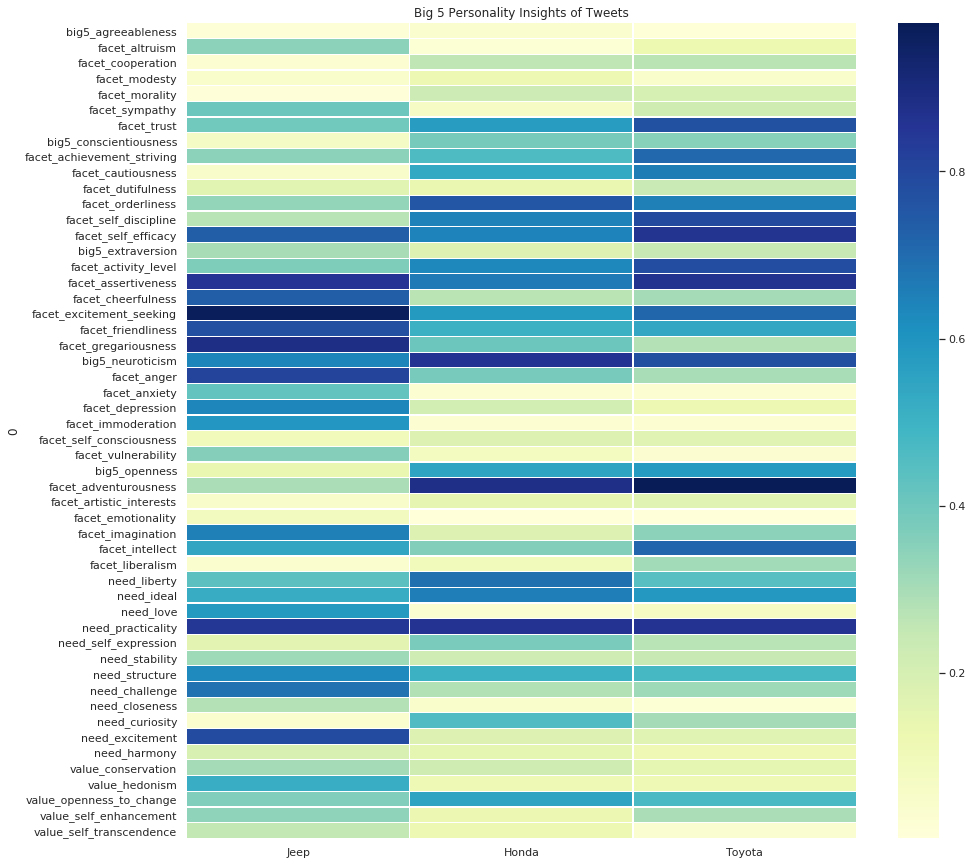

In [130]:
import seaborn as sns; sns.set()

plt.subplots(figsize=(15,15))
personalitydfT = personalitydfT[personalitydfT.columns].astype(float)  # or int
new_df = personalitydfT.transpose()
plt.title('Big 5 Personality Insights of Tweets')
ax = sns.heatmap(new_df, cmap="YlGnBu", linewidths = .2)